In [61]:
import pandas as pd
import numpy as np

from demoparser2 import DemoParser

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
from kneed import KneeLocator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules







In [62]:

# MAP_NAME = strings of maps (de_ancient, de_mirage, de_inferno, de_overpass, de_nuke, de_vertigo)
# side = 'T' or 'CT' (team name)
def smoke_df(MAP_NAME, side):
    
    df = pd.read_csv("IEM_DALLAS_2025_SMOKES.csv")  
    main_df = df.loc[df['map_name'] == MAP_NAME]
    t_smokes_df = main_df.loc[main_df['team_name'] == side]

    return t_smokes_df



In [63]:
# How to use: this function takes coordinates from df input and runs DBSCAN clustering on them.
# It returns the df with a new column 'cluster' that contains the cluster labels.
def smoke_clustering_dbscan(df):
    # Extract coordinates from the DataFrame
    coords = df[['x', 'y', 'z']].values

    # Run DBSCAN
    smoke_radius = 150
    dimensions = 3 # 3D coordinates (x, y, z)
    convention = dimensions * 2 # standard convention for min_samples in DBSCAN
    temp = DBSCAN(eps=smoke_radius, min_samples=convention).fit(coords)
    
    # Assign labels to the DataFrame
    df['cluster'] = temp.labels_
    return df




In [64]:
def plot_smoke_clusters_in_2d(main_df):
    plt.figure(figsize=(10, 8))
    
    for label in sorted(main_df['cluster'].unique()):
        cluster_df = main_df[main_df['cluster'] == label]
        color = 'k' if label == -1 else None
        
        # Plot points
        plt.scatter(cluster_df['x'], cluster_df['y'],
                    label=f'Cluster {label}' if label != -1 else 'Noise',
                    s=40, alpha=0.7, edgecolors='w', c=color)
        
        # Add label at centroid for each cluster (except noise)
        if label != -1:
            cx = cluster_df['x'].mean() - 100
            cy = cluster_df['y'].mean() - 100
            plt.text(cx, cy, str(label), fontsize=12, weight='bold',
                     ha='center', va='center', color='black',
                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    plt.xlabel("X (map units)")
    plt.ylabel("Y (map units)")
    plt.title("Top-Down 2D View of 3D Smoke Clusters")
    plt.grid(True)
    plt.axis("equal")
    plt.show()

In [65]:

# to be used for inference test later (WIP)
def get_round_wins_df(map_name, side):

    main_stats_df = pd.read_csv("demos.csv")
    if side == 'T':
        main_stats_df['is_T'] = (main_stats_df['round_ct_team'] != main_stats_df['team_name'])
        main_stats_df = main_stats_df[main_stats_df['is_T']]
    else:
        main_stats_df['is_CT'] = (main_stats_df['round_ct_team'] == main_stats_df['team_name'])
        main_stats_df = main_stats_df[main_stats_df['is_CT']]


    main_stats_df['is_win'] = (main_stats_df['round_result'] == 'CT') & (main_stats_df['round_ct_team'] == main_stats_df['team_name']) | (main_stats_df['round_result'] == 'T') & (main_stats_df['round_ct_team'] != main_stats_df['team_name'])
    round_wins = main_stats_df.drop_duplicates(subset=['team_name', 'round_number', 'is_win'])

    round_wins = round_wins[['team_name', 'round_id','round_number', 'is_win', 'map_name']]

    wins_df = round_wins[round_wins['map_name'] == map_name]
    
  
    return wins_df





In [66]:


def create_baskets(df):
    filtered_df = df[df['cluster'] != -1].copy()
    filtered_df = filtered_df.sort_values(by=['mapid', 'matchid', 'round_number', 'round_tick'])

    baskets = []

    # We group this because we want to create a basket for each smoke throwm in a round
    for _, round_df in filtered_df.groupby(['mapid', 'matchid', 'round_number']):
        round_df = round_df.reset_index(drop=True)

        for i in range(len(round_df)):
            base_tick = round_df.loc[i, 'round_tick']
            win_label = 'win' if round_df.loc[i, 'is_win'] else 'loss'

            # Get smokes within 640 ticks from this throw
            mask = (round_df['round_tick'] >= base_tick) & (round_df['round_tick'] <= base_tick + 640)
            clusters_in_window = round_df.loc[mask, 'cluster'].unique().tolist()

            if len(clusters_in_window) > 0:
                basket = [str(c) for c in clusters_in_window] + [win_label]

                baskets.append(basket)

    return baskets

In [67]:
def association_rule_mining(baskets):
    # Special thanks to https://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/ and 
    # https://www.geeksforgeeks.org/machine-learning/implementing-apriori-algorithm-in-python/ for the guide on ARM
    te = TransactionEncoder()
    te_ary = te.fit(baskets).transform(baskets)
    basket_df = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = apriori(basket_df, min_support=0.05, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

    # Step 7: Filter for rules where 'win' is the consequence
    win_rules = rules[rules['consequents'] == {'win'}]

    # Display the top rules
    print(win_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
    return win_rules
    

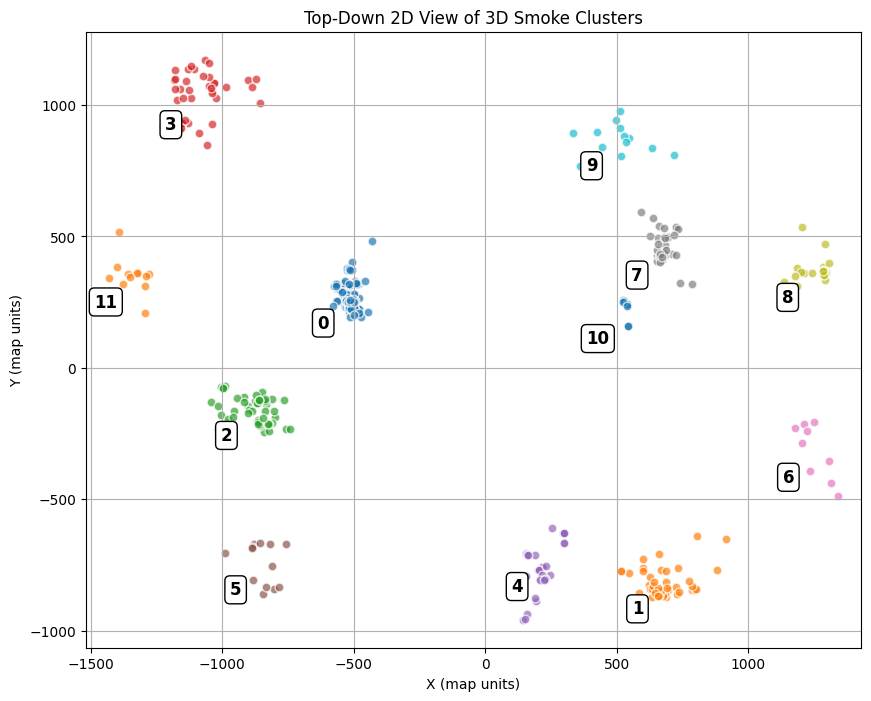

  antecedents consequents   support  confidence      lift
0         (0)       (win)  0.185268    0.610294  1.016401
1         (2)       (win)  0.136161    0.670330  1.116385
2         (7)       (win)  0.062500    0.622222  1.036266
3      (1, 0)       (win)  0.055804    0.609756  1.015505


In [68]:
MAP_NAME = 'de_ancient' # You can change this to any map name you want to analyze
SIDE = 'T'  # 'T' or 'CT'

main_df = smoke_df(MAP_NAME, SIDE)

main_df = smoke_clustering_dbscan(main_df)
baskets = create_baskets(main_df)
main_df = main_df[main_df['cluster'] != -1]  # Filter out noise clusters
plot_smoke_clusters_in_2d(main_df)

baskets = create_baskets(main_df)
win_rules = association_rule_mining(baskets)




In [69]:
import pandas as pd
from scipy.stats import chi2_contingency

contingency = pd.crosstab(main_df['cluster'], main_df['is_win'])
chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi-squared: {chi2}, p-value: {p}, degrees of freedom: {dof}")

Chi-squared: 17.372308513883553, p-value: 0.09733503190138845, degrees of freedom: 11


In [70]:
smoke_clusters_per_round = main_df.groupby('round_id')['cluster'].unique().to_dict()
round_df = get_round_wins_df(MAP_NAME, SIDE)
round_df = pd.merge(round_df, main_df[['round_id']], on='round_id', how='inner')
# Get list of unique clusters
all_clusters = sorted(main_df['cluster'].unique())

# Add binary flags for each cluster
for c in all_clusters:
    round_df[f'cluster_{c}'] = round_df['round_id'].apply(
        lambda rid: int(c in smoke_clusters_per_round.get(rid, []))
    )


antecedents = win_rules['antecedents']
 
for i, antecedent in enumerate(antecedents):
    cols = [f'cluster_{c}' for c in antecedent]
    clusters = ', '.join(sorted(map(str, antecedents[i])))
    round_df[f'antecedent_{clusters}'] = round_df[cols].all(axis=1).astype(int)


In [71]:
round_df

,team_name,round_id,round_number,is_win,map_name,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,...,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,antecedent_0,antecedent_2,antecedent_7,"antecedent_0, 1"
0,Team Liquid,3,4,True,de_ancient,1,1,1,1,0,...,0,0,0,0,0,0,1,1,0,1
1,Team Liquid,3,4,True,de_ancient,1,1,1,1,0,...,0,0,0,0,0,0,1,1,0,1
2,Team Liquid,3,4,True,de_ancient,1,1,1,1,0,...,0,0,0,0,0,0,1,1,0,1
3,Team Liquid,3,4,True,de_ancient,1,1,1,1,0,...,0,0,0,0,0,0,1,1,0,1
4,Team Liquid,4,5,True,de_ancient,1,0,1,0,1,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Team Falcons,555,1,False,de_ancient,1,0,1,0,1,...,0,1,1,0,0,0,1,1,1,0
135,Team Falcons,555,1,False,de_ancient,1,0,1,0,1,...,0,1,1,0,0,0,1,1,1,0
136,Team Falcons,555,1,False,de_ancient,1,0,1,0,1,...,0,1,1,0,0,0,1,1,1,0
137,Team Falcons,555,1,False,de_ancient,1,0,1,0,1,...,0,1,1,0,0,0,1,1,1,0


In [72]:
from scipy.stats import chi2_contingency

for c in all_clusters:
    contingency = pd.crosstab(round_df[f'cluster_{c}'], round_df['is_win'])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f"Cluster {c} → p = {p:.4f}")

for a, antecedent in enumerate(antecedents):
    clusters = ', '.join(sorted(map(str, antecedents[a])))
    contingency = pd.crosstab(round_df[f'antecedent_{clusters}'], round_df['is_win'])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f"Antecedent {a} → p = {p:.4f}")



Cluster 0 → p = 0.2280
Cluster 1 → p = 0.9251
Cluster 2 → p = 0.0052
Cluster 3 → p = 0.5260
Cluster 4 → p = 0.3285
Cluster 5 → p = 0.0009
Cluster 6 → p = 0.8229
Cluster 7 → p = 1.0000
Cluster 8 → p = 0.9193
Cluster 9 → p = 0.1121
Cluster 10 → p = 1.0000
Cluster 11 → p = 0.4077
Antecedent 0 → p = 0.2280
Antecedent 1 → p = 0.0052
Antecedent 2 → p = 1.0000
Antecedent 3 → p = 0.9251
